# CS6220 Project(Model)

### Download and extract Food 101 Dataset

In [33]:
import os

# Check if GPU is enabled
import tensorflow as tf
print(tf.__version__)
print(tf.test.gpu_device_name())


1.15.0
/device:GPU:0


In [0]:
# Helper function to download data and extract
import os
def get_data_extract():
  if "yelp" in os.listdir():
    print("Dataset already exists")
  else:
    !unzip -d ./yelp yelp.zip
    print("Extraction done!")


In [21]:
# Download data and extract it to folder
get_data_extract()

Archive:  yelp.zip
   creating: ./yelp/dumplings/
  inflating: ./yelp/dumplings/AEACZY655T7zGF8GOVOVXg.jpg  
  inflating: ./yelp/dumplings/o9RHBTwMiX8o2ayLyjoq0w.jpg  
  inflating: ./yelp/dumplings/j0-CyXKMDIP3ptpa_RLxJQ.jpg  
  inflating: ./yelp/dumplings/wy9THHoxNJ7CQIXyhmCtqg.jpg  
  inflating: ./yelp/dumplings/x9ERnNUysD40_sty2s1zqA.jpg  
  inflating: ./yelp/dumplings/nFW03Ysvraz_dm_EXWP5AQ.jpg  
  inflating: ./yelp/dumplings/MMGBvvmd2yXrXyqyKiQWig.jpg  
  inflating: ./yelp/dumplings/2rdNhsOs9iaRQeHBxSesMQ.jpg  
  inflating: ./yelp/dumplings/1nI_j2gsRyvMfkC8lsMnxw.jpg  
  inflating: ./yelp/dumplings/OyUD7nr16mJbKWGLvjVqkg.jpg  
  inflating: ./yelp/dumplings/4YxzfE6znbjVnol1b_Xyfw.jpg  
  inflating: ./yelp/dumplings/NX1Ed69kRYQk8gyyFIx9fA.jpg  
  inflating: ./yelp/dumplings/wxqG7_8K3hDnOq4Cxb9AqQ.jpg  
  inflating: ./yelp/dumplings/0fSi26-XETG7XMX3qVq3-Q.jpg  
  inflating: ./yelp/dumplings/H8kM777_AhHv8-qdKlR-8Q.jpg  
  inflating: ./yelp/dumplings/0sq8p8TyUjSdlzb7aiX_Ng.jpg  
  infl

### Split the datasets into train and test 


In [34]:
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
import os
import random
from shutil import copy
foodList =  ["cheesecake", "mussels", "waffles", "pizza", "fried_rice", "dumplings",  "steak", "tacos", "donuts", "sushi"]

def prepare_data(food, src,train, test):
    print("Food ", food)
    if not os.path.exists(os.path.join(train,food)):
        os.makedirs(os.path.join(train,food))
    if not os.path.exists(os.path.join(test,food)):
        os.makedirs(os.path.join(test,food))
    photoList =os.listdir(os.path.join('./yelp',food))
    random.shuffle(photoList)
    split1 = 75
    split2 = 100
    for photoId in photoList[:split1]:
        copy(os.path.join(src, photoId),os.path.join(train, food, photoId))
    for photoId in photoList[split1:split2]:
        copy(os.path.join(src, photoId),os.path.join(test, food, photoId))
    print("Copying Finished!")

for food in foodList:
    prepare_data(food, os.path.join('./yelp',food), "./train", "./test")






Food  cheesecake
Copying Finished!
Food  mussels
Copying Finished!
Food  waffles
Copying Finished!
Food  pizza
Copying Finished!
Food  fried_rice
Copying Finished!
Food  dumplings
Copying Finished!
Food  steak
Copying Finished!
Food  tacos
Copying Finished!
Food  donuts
Copying Finished!
Food  sushi
Copying Finished!


In [31]:
print("Total number of samples in train folder")
!find train -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
750


In [32]:
# Check how many files are in the test folder
print("Total number of samples in test folder")
!find test -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
250


### Fine tune Inceptionv3 model with 10 classes of data

In [36]:
# Let's use a pretrained Inceptionv3 model on subset of data with 10 food classes
n = 10 

food_list = ["cheesecake", "mussels", "waffles", "pizza", "fried_rice", "dumplings",  "steak", "tacos", "donuts", "sushi"]

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
import numpy as np

K.clear_session()

n_classes = n
img_width, img_height = 299, 299
train_data_dir = 'train'
validation_data_dir = 'test'
nb_train_samples = 8250 #75750
nb_validation_samples = 2750 #25250
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


inception = InceptionV3(weights='imagenet', include_top=False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(n,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_10class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history.log')

history = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=10,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])
model.save('model_inceptionV3_dataSet_yelp.hdf5')


Found 750 images belonging to 10 classes.
Found 250 images belonging to 10 classes.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
87916544/87910968 [==============================] - 7s 0us/step
Epoch 1/10
171/515 [========>.....................] - ETA: 42s - loss: 1.9537 - acc: 0.4675
Epoch 00001: val_loss improved from inf to 1.95374, saving model to best_model_10class.hdf5
515/515 [==============================] - 306s 594ms/step - loss: 2.1722 - acc: 0.2956 - val_loss: 1.9537 - val_acc: 0.4675
Epoch 2/10
171/515 [========>.....................] - ETA: 40s - loss: 1.5150 - acc: 0.5897
Epoch 00002: val_loss improved from 1.95374 to 1.51497, saving model to best_model_10class.hdf5
515/515 [==============================] - 242s 469ms/step - loss: 1.5141 - acc: 0.6269 - val_loss: 1.5150 - val_acc: 0.5897
Epoch 3/10
171/515 [========>.....................] - ETA: 40s - loss: 1.3326 - acc: 0.6076
Epoch 00003: val_loss improved from 1.51497 to 1.33258, 

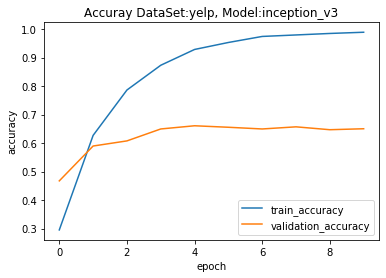

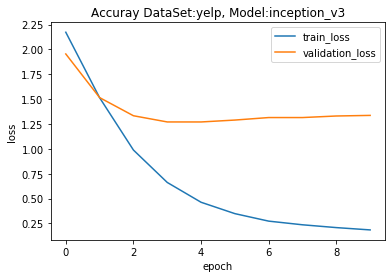

In [38]:


import matplotlib.pyplot as plt
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()
def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()



plot_accuracy(history,'Accuray DataSet:yelp, Model:inception_v3')
plot_loss(history,'Accuray DataSet:yelp, Model:inception_v3')

###Do predictions for new image![alt text](https://)


In [0]:
# Loading the best saved model to make predictions
%%time
from tensorflow.keras.models import load_model
K.clear_session()
model_best = load_model('best_model_10class.hdf5',compile = False)

from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
from google.colab import files
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img /= 255.                                      

    pred = model.predict(img)
    index = np.argmax(pred)
    food_list.sort()
    pred_value = food_list[index]
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()
images = files.upload()
predict_class(model_best, images, True)

KeyboardInterrupt: ignored